In [31]:
# Install required libraries
%pip install torch torchaudio transformers datasets scikit-learn numpy matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [33]:
import torch
device = torch.device('cpu')
audio_embeddings = torch.load('audio_embeddings.pt', map_location=device)

print(len(audio_embeddings))

80


In [34]:
# Load dataset
audio_dataset = load_dataset(
    'TrainingDataPro/speech-emotion-recognition-dataset',
    split='train'
)

def convert_to_target(emotion):
    if emotion == 'euphoric':
        return 1
    elif emotion == 'joyfully':
        return 2
    elif emotion == 'sad':
        return 3
    elif emotion == 'surprised':
        return 4
    else:
        return -1

emotions = ['euphoric', 'joyfully', 'sad', 'surprised']
targets = []

for emotion in emotions:
    for sample in audio_dataset[emotion]:
        targets.append(convert_to_target(emotion))

In [35]:
# Flatten embeddings
flattened_embeddings = [embedding.view(-1) for embedding in audio_embeddings]
embedding_matrix = torch.stack(flattened_embeddings)

# Convert embeddings from tensor to numpy arrays
embedding_matrix = embedding_matrix.detach().cpu().numpy()
print(embedding_matrix.shape)
print(embedding_matrix)

(80, 512)
[[-0.0197334  -0.00249679  0.11328787 ... -0.08363502  0.04762014
   0.08813638]
 [-0.01700936 -0.00169819  0.12584828 ... -0.08392757  0.05042014
   0.0900396 ]
 [-0.01665157 -0.00179881  0.11708343 ... -0.0858629   0.04423774
   0.08991268]
 ...
 [-0.01731364 -0.00215796  0.11473525 ... -0.0838877   0.04435505
   0.08995587]
 [-0.01807118 -0.00259435  0.11262784 ... -0.08339463  0.04653695
   0.08947439]
 [-0.01466641 -0.00274683  0.1172166  ... -0.08552615  0.04621886
   0.09083286]]


In [36]:
NUM_TRAINING = 15

def create_splits(data, targets):
    train_data = []
    train_targets = []
    test_data = []
    test_targets = []
    
    for index in range(80):
        if index % 20 < NUM_TRAINING:
            train_data.append(data[index])
            train_targets.append(targets[index])
        else:
            test_data.append(data[index])
            test_targets.append(targets[index])
    
    return train_data, test_data, train_targets, test_targets

In [37]:
# Get train and test data sets
X_train, X_test, y_train, y_test = create_splits(embedding_matrix, targets)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Your existing RandomForestClassifier setup
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Create a GridSearchCV object with RandomForestClassifier as the estimator
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best estimator (RandomForest model with best-found parameters)
model = grid_search.best_estimator_


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=

In [39]:
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_accuracy = accuracy_score(train_pred, y_train)
test_accuracy = accuracy_score(test_pred, y_test)
train_f1 = f1_score(train_pred, y_train, average="weighted")
test_f1 = f1_score(test_pred, y_test, average="weighted")

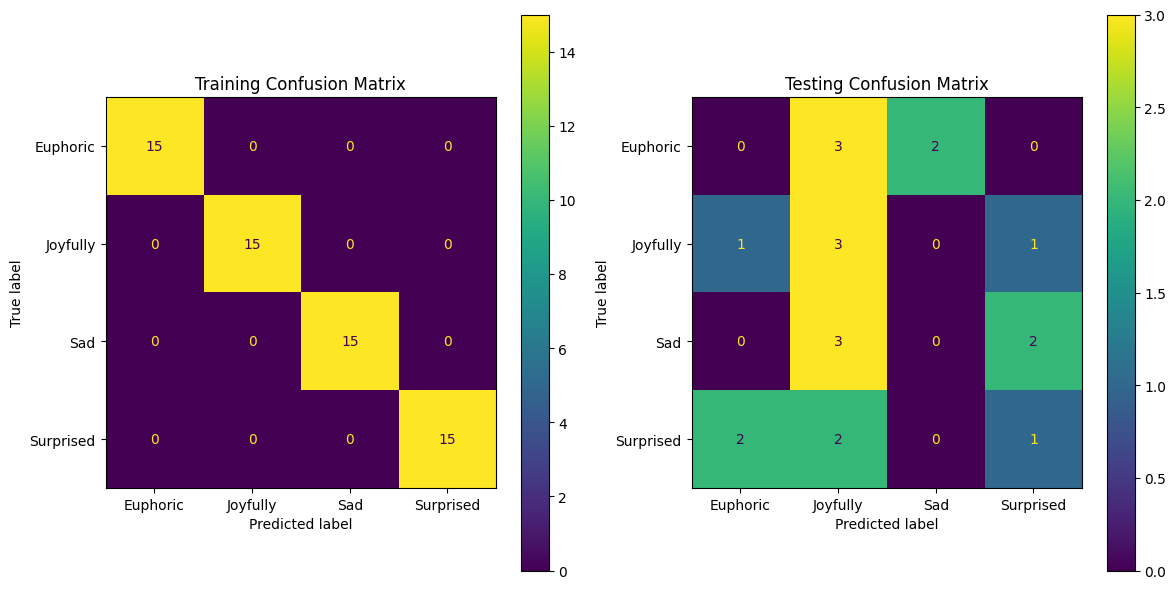

Training Accuracy: 1.0
Testing Accuracy: 0.2
Training F-measure: 1.0
Testing F-measure: 0.25069


In [40]:
# Visualize confusion matrices
labels = ['Euphoric', 'Joyfully', 'Sad', 'Surprised']

train_cm = confusion_matrix(y_train, train_pred, labels=[1, 2, 3, 4])
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=labels)

test_cm = confusion_matrix(y_test, test_pred, labels=[1, 2, 3, 4])
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=labels)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
train_disp.plot(ax=ax[0])
ax[0].set_title("Training Confusion Matrix")
test_disp.plot(ax=ax[1])
ax[1].set_title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

# Print accuracy scores
print("Training Accuracy:", round(train_accuracy, 5))
print("Testing Accuracy:", round(test_accuracy, 5))
print("Training F-measure:", round(train_f1, 5))
print("Testing F-measure:", round(test_f1, 5))